In [1]:
import os
import pretty_midi
import numpy as np
import os
import pretty_midi
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


2024-08-12 12:01:51.531791: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Path to the directory containing MIDI files
base_dir = './Composer_Dataset/NN_midi_files_extended/train'


# List of folders (composers) within the base directory
composer_folders = os.listdir(base_dir)

# Initialize a list to store all loaded MIDI data
all_midi_data = []

# Function to load MIDI files from the specified directory
def load_midi_files(base_dir):
    # Loop through each composer folder
    for composer_folder in composer_folders:
        composer_path = os.path.join(base_dir, composer_folder)
        
        # Check if the item in the base directory is a folder
        if os.path.isdir(composer_path):
            print(f"Loading MIDI files from {composer_folder}...")
            
            # Loop through each MIDI file in the composer folder
            for file_name in os.listdir(composer_path):
                file_path = os.path.join(composer_path, file_name)
                
                # Check if the item in the composer folder is a file and has a .mid or .midi extension
                if os.path.isfile(file_path) and (file_name.endswith('.mid')):
                    midi_data = pretty_midi.PrettyMIDI(file_path)
                    all_midi_data.append({
                        'composer': composer_folder,
                        'file_name': file_name,
                        'midi_data': midi_data
                    })
                    print(f"  Loaded: {file_name}")

    print("All MIDI files loaded successfully!")
    return all_midi_data

# Load all MIDI files from the specified directory
all_midi_data = load_midi_files(base_dir)


Loading MIDI files from mozart...
  Loaded: mozart048.mid
  Loaded: mozart028.mid


/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


  Loaded: mozart000.mid
  Loaded: mozart001.mid
  Loaded: mozart015.mid
  Loaded: mozart029.mid
  Loaded: mozart003.mid
  Loaded: mozart017.mid
  Loaded: mozart016.mid
  Loaded: mozart002.mid
  Loaded: mozart006.mid
  Loaded: mozart012.mid
  Loaded: mozart013.mid
  Loaded: mozart007.mid
  Loaded: mozart011.mid
  Loaded: mozart005.mid
  Loaded: mozart010.mid
  Loaded: mozart009.mid
  Loaded: mozart021.mid
  Loaded: mozart034.mid
  Loaded: mozart008.mid
  Loaded: mozart022.mid
  Loaded: mozart036.mid
  Loaded: mozart037.mid
  Loaded: mozart023.mid
  Loaded: mozart027.mid
  Loaded: mozart033.mid
  Loaded: mozart032.mid
  Loaded: mozart026.mid
  Loaded: mozart030.mid
  Loaded: mozart024.mid
  Loaded: mozart018.mid
  Loaded: mozart019.mid
  Loaded: mozart031.mid
  Loaded: mozart042.mid
  Loaded: mozart043.mid
  Loaded: mozart041.mid
  Loaded: mozart044.mid
  Loaded: mozart045.mid
  Loaded: mozart047.mid
  Loaded: mozart046.mid
Loading MIDI files from chopin...
  Loaded: chopin054.mid
  Load

# Feature Engineering

In [3]:

# Initialize lists to store extracted features
num_instruments_list = []
instruments_list_list = []
num_programs_list = []
tempo_list = []
composer_list = []
resolution_list = []
time_signature_ratio_list = []
duration_list = []
average_pitch_list = []

# Function to extract features from MIDI data
def feature_extraction(midi_data):
    # Loop through all loaded MIDI data
    for data in all_midi_data:
        midi_data = data['midi_data']
        
        # Extract the number of instruments
        num_instruments = len(midi_data.instruments)
        num_instruments_list.append(num_instruments)
        
        # Extract the list of instruments
        instruments_list = [instrument.program for instrument in midi_data.instruments]
        # flatten the list
        instruments_list_list.append(instruments_list)
        
        # Extract the number of programs
        num_programs = len(set(instruments_list))
        num_programs_list.append(num_programs)
        
        # Extract the tempo
        tempo = midi_data.estimate_tempo()
        tempo_list.append(tempo)
        
        # Extract the composer name
        composer = data['composer']
        composer_list.append(composer)

        # resolution
        resolution = midi_data.resolution
        resolution_list.append(resolution)

        #time_signature_ratio- Take numerator and denominator of time signature and divide them
        if len(midi_data.time_signature_changes) <=0:
            time_signature_ratio = 0
            time_signature_ratio_list.append(time_signature_ratio)
        else:
            time_sig_numerator =  midi_data.time_signature_changes[0].numerator
            time_sig_denominator = midi_data.time_signature_changes[0].denominator
            time_signature_ratio = time_sig_numerator/time_sig_denominator
            time_signature_ratio_list.append(time_signature_ratio)

        # duration
        duration = midi_data.get_end_time()
        duration_list.append(duration)

        # average_pitch
        pitch_list = []
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                pitch_list.append(note.pitch)
        average_pitch = np.mean(pitch_list)
        average_pitch_list.append(average_pitch)


    # # Create a DataFrame to store the extracted features
    import pandas as pd
    df = pd.DataFrame({
        'composer': composer_list,
        'num_instruments': num_instruments_list,
        'instruments_list': instruments_list_list,
        'num_programs': num_programs_list,
        'tempo': tempo_list,
        'resolution': resolution_list,
        'time_signature_ratio': time_signature_ratio_list,
        'duration': duration_list,
        'average_pitch': average_pitch_list
    })

    return df

# Extract features from the loaded MIDI data
df = feature_extraction(all_midi_data)
print('Feature extraction complete!')
df.head()

Feature extraction complete!


,composer,num_instruments,instruments_list,num_programs,tempo,resolution,time_signature_ratio,duration,average_pitch
0,mozart,3,"[71, 48, 48]",2,212.535066,384,0.75,560.663049,66.946237
1,mozart,3,"[73, 0, 0]",2,204.217618,384,0.75,466.869171,67.940145
2,mozart,17,"[68, 68, 60, 73, 46, 48, 45, 48, 45, 48, 45, 4...",7,186.893827,480,1.00,1633.033539,66.247318
3,mozart,6,"[0, 0, 68, 71, 60, 70]",5,183.306595,384,1.00,512.690999,65.775732
4,mozart,6,"[0, 0, 48, 45, 48, 45]",3,217.923095,384,1.00,329.689706,62.552919


# Data Exploration

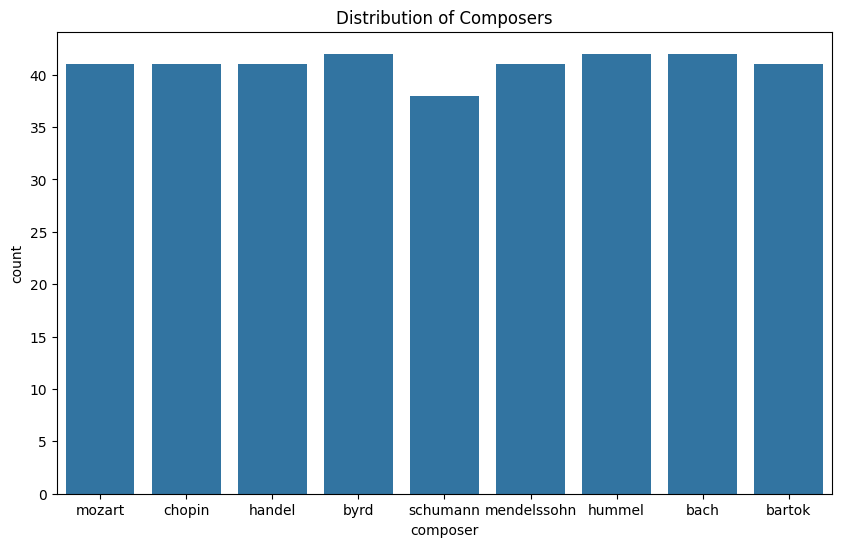

In [4]:
# Display the number of unique composers
df['composer'].value_counts()

# Display the distribution of composers
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='composer')
plt.title('Distribution of Composers')
plt.show()


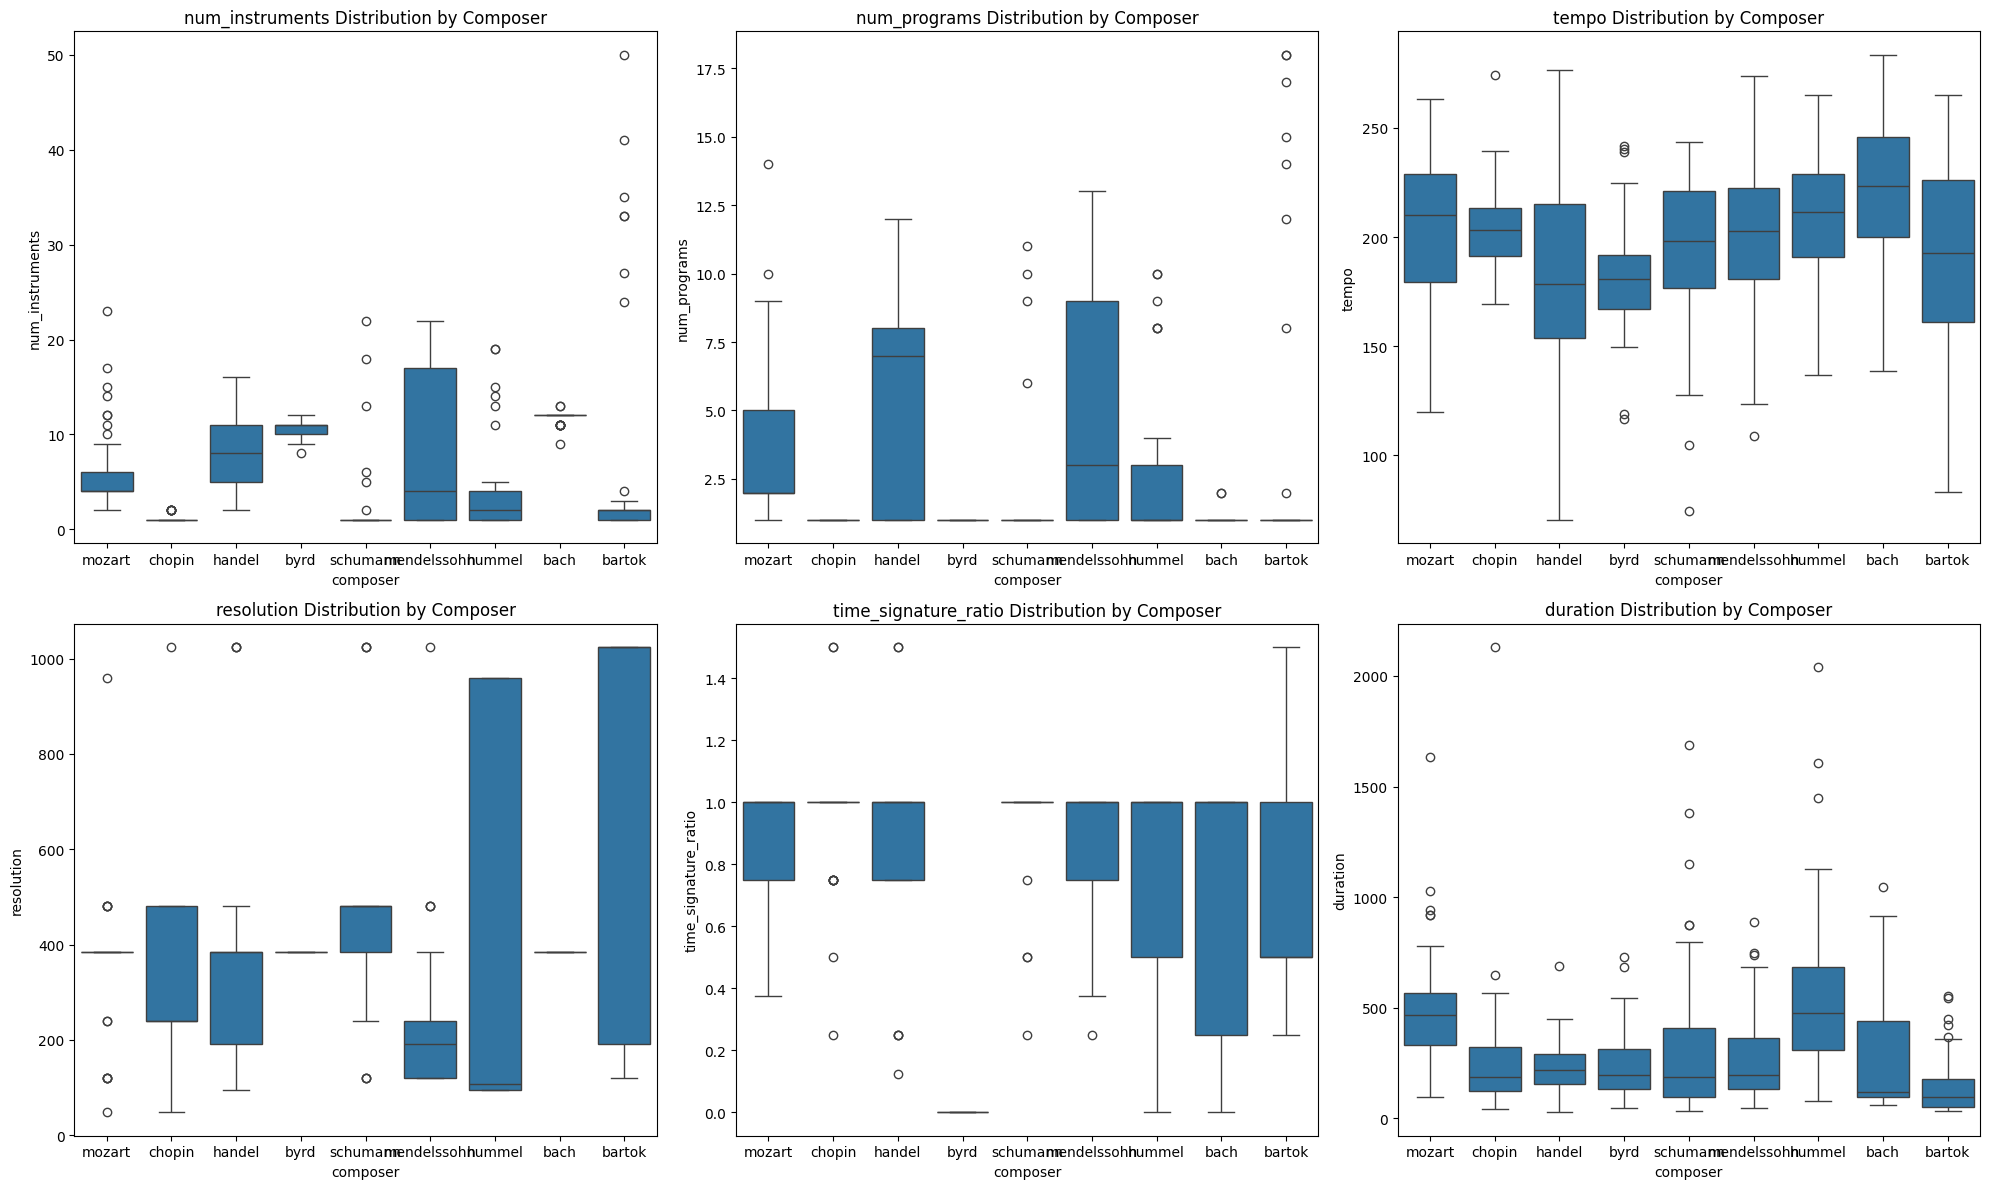

In [5]:
# Create a list of features to plot
features = ['num_instruments', 'num_programs', 'tempo', 'resolution', 'time_signature_ratio', 'duration', 'average_pitch']

# Plot the feature distributions side by side 
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
for i, feature in enumerate(features):
    if feature == 'average_pitch':
        continue
    sns.boxplot(data=df, x='composer', y=feature, ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'{feature} Distribution by Composer')
plt.tight_layout()
plt.show()




# Preprocessing

In [6]:
# Outlier Removal
from scipy.stats import zscore

# Calculate the z-scores of each feature in the DataFrame
z_scores = df[features].apply(zscore)

# Find the indices of rows with outliers
outlier_indices = z_scores[(z_scores > 3).any(axis=1)].index

# Remove rows with outliers
df_clean = df.drop(outlier_indices)

# Display the number of rows in the cleaned dataset
num_rows_clean = len(df_clean)
print(f"Number of rows in the cleaned dataset: {num_rows_clean}")

# loop through each feature and check for outliers
for feature in features:
    # Calculate the first and third quartiles
    q1 = df_clean[feature].quantile(0.25)
    q3 = df_clean[feature].quantile(0.75)
    
    # Calculate the interquartile range
    iqr = q3 - q1
    
    # Calculate the lower and upper bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Find the indices of rows with outliers
    outlier_indices = df_clean[(df_clean[feature] < lower_bound) | (df_clean[feature] > upper_bound)].index
    
    # Remove rows with outliers
    df_clean = df_clean.drop(outlier_indices)
    
    # Display the number of rows removed
    num_outliers = len(outlier_indices)
    
    print(f"Removed {num_outliers} outliers from the dataset for {feature}")

# Display the number of rows in the cleaned dataset
num_rows_clean = len(df_clean)

print(f"Number of rows in the cleaned dataset: {num_rows_clean}")



Number of rows in the cleaned dataset: 353
Removed 0 outliers from the dataset for num_instruments
Removed 71 outliers from the dataset for num_programs
Removed 5 outliers from the dataset for tempo
Removed 33 outliers from the dataset for resolution
Removed 0 outliers from the dataset for time_signature_ratio
Removed 11 outliers from the dataset for duration
Removed 8 outliers from the dataset for average_pitch
Number of rows in the cleaned dataset: 225


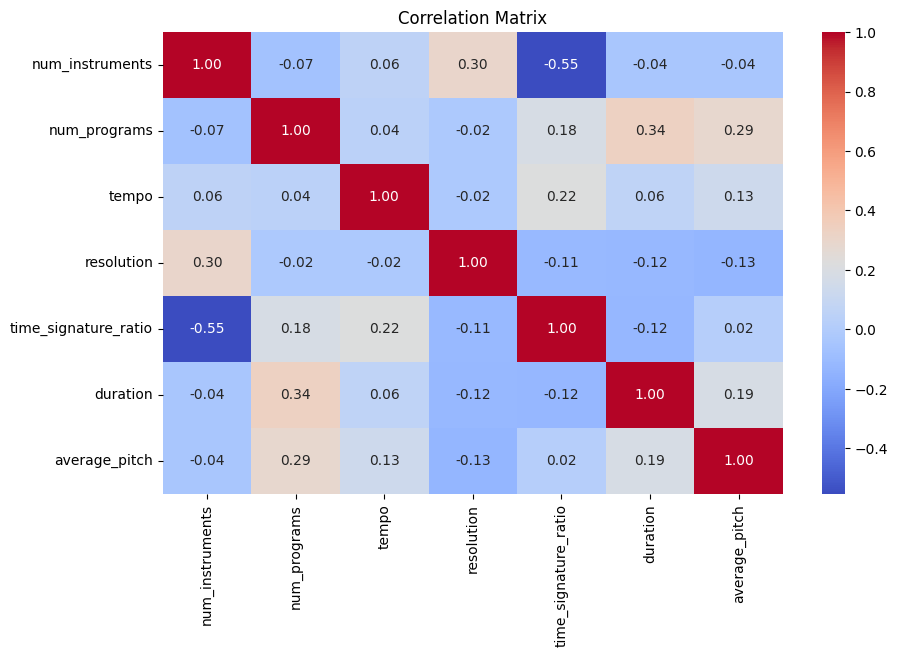

In [7]:
# Correlation Matrix
corr = df_clean[features].corr()

# Display the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



# Normalization and Encoding

In [8]:
# Normalize the features using Min-Max scaling
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the features
df_scaled = df_clean.copy()
df_scaled[features] = scaler.fit_transform(df_clean[features])

# Display the first few rows of the normalized DataFrame
df_scaled.head()

label_encoder = LabelEncoder()
df_scaled['composer_encoded'] = label_encoder.fit_transform(df_scaled['composer'])

# Define the input features (X) and the target (y)
X = df_scaled[features].values
y = df_scaled['composer_encoded'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape the input features
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

# Approach A: CNN Model

In [12]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional

# Reshape the input features for CNN
X_train_cnn = X_train # .reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test # .reshape(X_test.shape[0], X_test.shape[1], 1)

# Convert the target to categorical
num_classes = len(np.unique(y))
y_train_cnn = to_categorical(y_train, num_classes)
y_test_cnn = to_categorical(y_test, num_classes)

# Build the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_cnn, y_train_cnn, epochs=5, batch_size=32, validation_data=(X_test_cnn, y_test_cnn))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

ValueError: Exception encountered when calling layer "conv1d" (type Conv1D).

Negative dimension size caused by subtracting 2 from 1 for '{{node conv1d/Conv1D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](conv1d/Conv1D/ExpandDims, conv1d/Conv1D/ExpandDims_1)' with input shapes: [?,1,1,1], [1,2,1,64].

Call arguments received by layer "conv1d" (type Conv1D):
  • inputs=tf.Tensor(shape=(None, 1, 1), dtype=float32)

# Approach B: RNN Model

In [13]:
# Define a function to create the LSTM model
def create_lstm_model(units, dropout_rate, input_shape):
    model = Sequential([
        LSTM(units, input_shape=input_shape, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 2, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(units // 4),
        Dropout(dropout_rate),
        Dense(units // 8, activation='relu'),
        Dense(units // 16, activation='relu'),
        Dense(units // 32, activation='relu'),
        Dense(11, activation='softmax')
    ])
    return model

# Define the hyperparameters to tune
units = [2048]

# Define the dropout rates to tune
dropout_rates = [ 0.2]

# Define the input shape
input_shape = (X_train.shape[1], X_train.shape[2])

# Initialize a list to store the results
results = []

# Loop through each combination of hyperparameters
for unit in units:
    for dropout_rate in dropout_rates:
        # Create the LSTM model
        model = create_lstm_model(unit, dropout_rate, input_shape)
        
        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
        
        # Evaluate the model
        accuracy = model.evaluate(X_train, y_train, verbose=0)
        accuracy_percentage = accuracy[1] * 100
        
        # Store the results
        results.append({
            'units': unit,
            'dropout_rate': dropout_rate,
            'accuracy': accuracy_percentage
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
results_df

# Storing variable for comparison later
history_rnn = history



2024-08-12 12:08:06.692766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-12 12:08:06.695285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-12 12:08:06.697097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/100


2024-08-12 12:08:08.693202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-12 12:08:08.695378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-12 12:08:08.696623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - ETA: 0s - loss: 2.3893 - accuracy: 0.1389

2024-08-12 12:08:15.735218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-12 12:08:15.736421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-12 12:08:15.737756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 8s 592ms/step - loss: 2.3893 - accuracy: 0.1389 - val_loss: 2.3438 - val_accuracy: 0.2222
Epoch 2/100
5/5 [==============================] - 1s 307ms/step - loss: 2.2937 - accuracy: 0.1667 - val_loss: 2.0817 - val_accuracy: 0.2222
Epoch 3/100
5/5 [==============================] - 2s 312ms/step - loss: 2.1499 - accuracy: 0.1667 - val_loss: 1.9944 - val_accuracy: 0.2222
Epoch 4/100
5/5 [==============================] - 2s 327ms/step - loss: 2.0550 - accuracy: 0.1667 - val_loss: 1.9120 - val_accuracy: 0.2222
Epoch 5/100
5/5 [==============================] - 2s 317ms/step - loss: 1.9711 - accuracy: 0.2222 - val_loss: 1.7507 - val_accuracy: 0.3333
Epoch 6/100
5/5 [==============================] - 2s 312ms/step - loss: 1.8582 - accuracy: 0.2569 - val_loss: 1.6092 - val_accuracy: 0.3333
Epoch 7/100
5/5 [==============================] - 2s 344ms/step - loss: 1.7646 - accuracy: 0.3472 - val_loss: 1.5021 - val_accuracy: 0.5000
Epoch 8/100
5/5 [========

# Classification Report

2024-08-12 12:11:31.994242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-12 12:11:31.996391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-12 12:11:31.997940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 1s 17ms/step


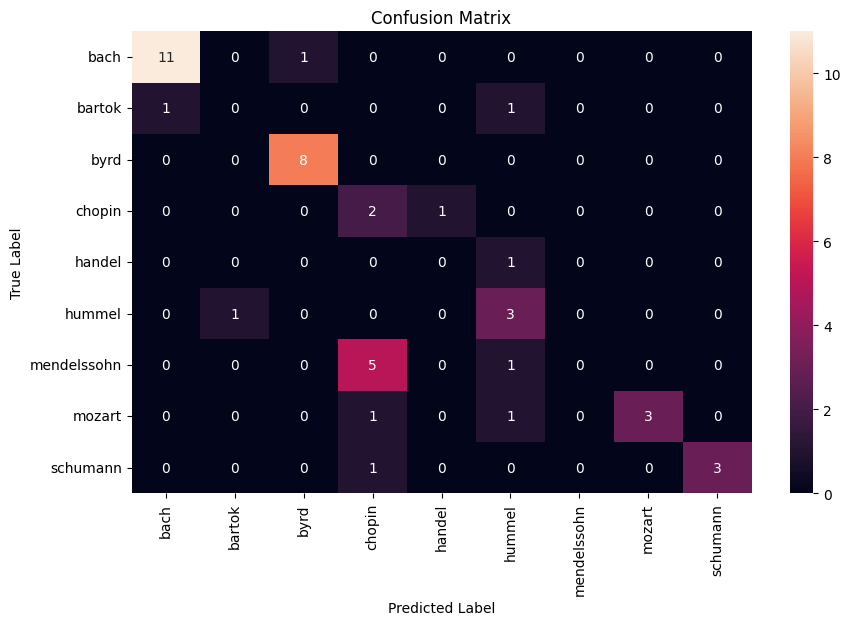

              precision    recall  f1-score   support

        bach       0.92      0.92      0.92        12
      bartok       0.00      0.00      0.00         2
        byrd       0.89      1.00      0.94         8
      chopin       0.22      0.67      0.33         3
      handel       0.00      0.00      0.00         1
      hummel       0.43      0.75      0.55         4
 mendelssohn       0.00      0.00      0.00         6
      mozart       1.00      0.60      0.75         5
    schumann       1.00      0.75      0.86         4

    accuracy                           0.67        45
   macro avg       0.50      0.52      0.48        45
weighted avg       0.66      0.67      0.64        45



/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
# predict the test data
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
y_pred = model.predict(X_test)

# Convert the predicted values to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_labels, target_names=label_encoder.classes_))

# Storing variable for later
cm_rnn = cm



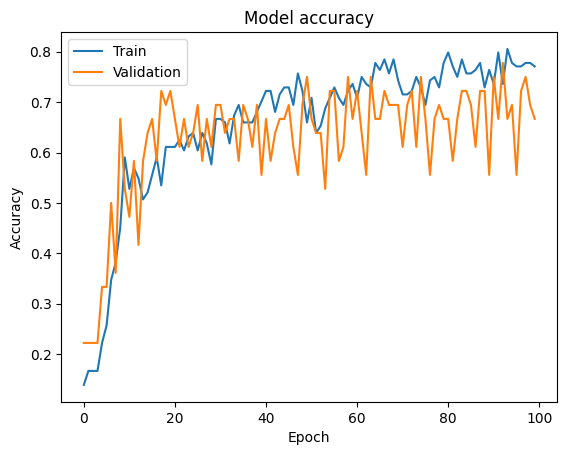

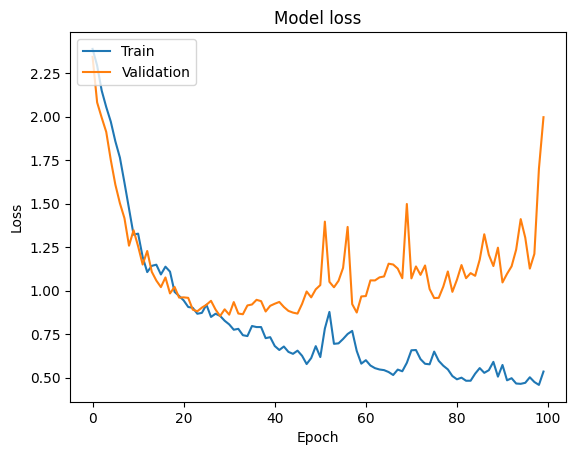

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Approach C: RNN + CNN Model

In [18]:
import os
import pretty_midi
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

model = Sequential([
    # CNN part - Adding another Conv1D and MaxPooling1D layer to make it deeper
    Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=1),
    Conv1D(filters=128, kernel_size=1, activation='relu'),  # New Conv1D layer
    MaxPooling1D(pool_size=1),  # New MaxPooling1D layer
    
    # RNN part - Adding another LSTM layer to make it deeper
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),  # New LSTM layer
    Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)),
    
    # Fully connected part - Adding an additional dense layer
    Dense(units=256, activation='relu'),  # Increased units and added this layer
    Dropout(0.5),
    Dense(units=128, activation='relu'),
    Dropout(0.5),
    
    # Output layer
    Dense(units=len(np.unique(y_train)), activation='softmax')
])

# Compile and train the model as before
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Save variable for later
histort_rnncnn = history




Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1, 64)            0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            8320      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 128)           0         
 1D)                                                             
                                                                 
 bidirectional (Bidirectiona  (None, 1, 256)           263168    
 l)                                                              
                                                      

2/2 [==============================] - 0s 6ms/step - loss: 0.9382 - accuracy: 0.7111
Test accuracy: 0.7111111283302307
2/2 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.00      0.00      0.00         2
           2       0.89      1.00      0.94         8
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         1
           5       0.50      0.75      0.60         4
           6       0.40      0.33      0.36         6
           7       1.00      0.60      0.75         5
           8       0.67      1.00      0.80         4

    accuracy                           0.71        45
   macro avg       0.53      0.55      0.53        45
weighted avg       0.72      0.71      0.70        45



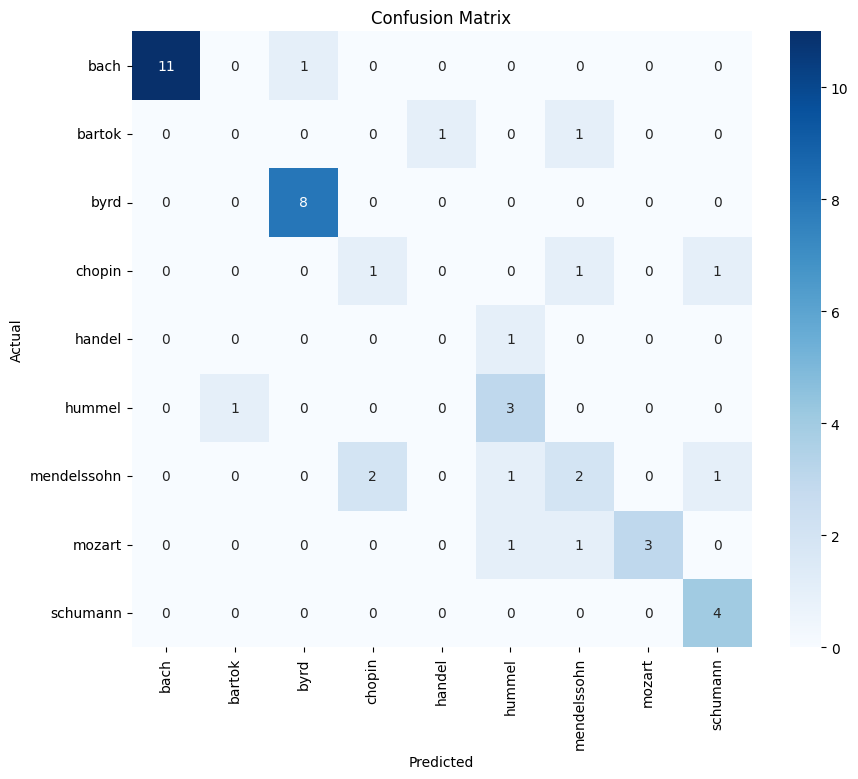

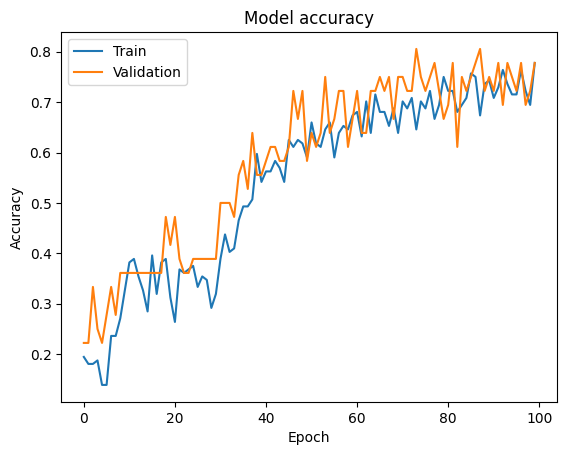

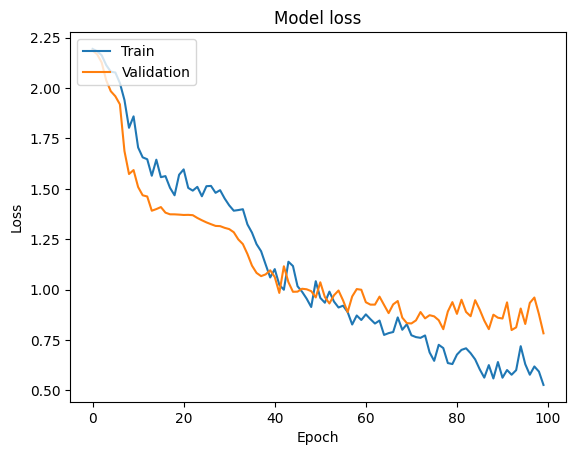

In [19]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Predict the classes for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generate the classification report
report = classification_report(y_test, y_pred_classes)
print("Classification Report:")
print(report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Summary

1. CNN Accuracy = TBD
2. RNN Accuracy = 0.67
3. CNN + RNN Accuracy = 0.71